In [ ]:
pip install "dask[complete]"

In [ ]:
pip install dask-ml

In [ ]:
!pip3 install emoji
!pip3 install langdetect

In [ ]:
import dask.dataframe as dd
from dask_ml.feature_extraction.text import CountVectorizer
from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from dask_ml.linear_model import LogisticRegression
from nltk.corpus import stopwords
import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

In [5]:
from google.colab import drive
drive.mount('/content/drive')
basePath = "/content/drive/My Drive/Colab Notebooks/LSDM/Tweets/"

Mounted at /content/drive


In [6]:
from nltk.metrics.association import ContingencyMeasures
depression_stress_words = {
    'anxious', 'lonely', 'hopeless', 'empty', 'helpless', 'worthless', 'tired', 'exhausted', 'fatigued', 'miserable',
    'hopelessness', 'numb', 'irritable', 'sorrow', 'suffering', 'suicidal', 'tearful', 'troubled', 'vulnerable', 'crisis',
    'despair', 'disheartened', 'dismal', 'downhearted', 'forlorn', 'gloomy', 'grief', 'melancholy', 'mournful', 'sad',
    'tragic', 'unhappy', 'dejected', 'demoralized', 'devastated', 'discouraged', 'downtrodden', 'low-spirited', 'blue',
    'heartbroken', 'hurt', 'injured', 'pained', 'distressed', 'tormented', 'angry', 'annoyed', 'frustrated', 'irritated',
    'fearful', 'afraid', 'scared', 'terrified', 'worried', 'concerned', 'anxiety', 'panic', 'stress', 'depression', 'suicide',
    'self-harm', 'overwhelmed', 'pressure', 'mental health', 'loneliness', 'isolation', 'disconnected', 'unloved', 'unworthy',
    'worthlessness', 'worthless', 'rejected', 'failure', 'inadequate', 'guilty', 'ashamed', 'self-blame', 'negativity', 'hopeless',
    'meaningless', 'numbness', 'apathy', 'loss', 'trapped', 'confused', 'disoriented', 'disillusioned', 'betrayed', 'humiliated',
    'empty', 'exhausted', 'fatigue', 'irritability', 'anger', 'rage', 'mood swings', 'insomnia', 'sleep problems', 'nightmares',
    'loss of interest', 'withdrawal', 'social withdrawal', 'lethargic', 'energy loss', 'pessimism', 'dysphoria', 'bad mood',
    'foggy', 'lethargy', 'inability to concentrate'
}

stress_scores = {'death': 5, 'emergency': 4, 'urgent': 4, 
                           'crisis': 4, 'trauma': 4, 'disaster': 4, 
                           'injury': 4, 'hospital': 4, 'catastrophe': 4, 
                           'danger': 3, 'threat': 3, 'violence': 3, 'crime': 3,
                           'attack': 3, 'fear': 3, 'panic': 3, 'anxiety': 3, 
                           'terror': 3, 'conflict': 2, 'pressure': 1, 
                           'deadline': 2, 'overwhelmed': 2, 'frustrated': 2, 
                           'exhausted': 2, 'tired': 2, 'fatigue': 2, 'stress': 2, 
                           'anxious': 2, 'challenging': 1, 'difficult': 1, 'complicated': 1,
                           'busy': 1, 'demanding': 1, 'responsibility': 1, 
                           'workload': 1, 'expectations': 1, 'change': 1,
                           'uncertainty': 1, 'unknown': 1, 'new': 1, 
                           'fired': 3, 'laid off': 3, 'termination': 3,
                           'budget cuts': 2, 'bankruptcy': 4, 'divorce': 4, 
                           'break-up': 3, 'death of a loved one': 4, 
                           'health issues': 3, 'major life changes': 2, 
                           'financial problems': 3, 'relationship issues': 2, 
                           'loneliness': 2, 'isolation': 2, 'rejection': 2, 
                           'failure': 2, 'disappointment': 1, 'homesick': 1, 
                           'missing someone': 1, 'nostalgia': 1, 'gratitude': -2, 
                           'joy': -2, 'happiness': -2, 'relief': -2, 'satisfaction': -2, 
                           'contentment': -2, 'calm': -2, 'peace': -2, 'tranquility': -2, 
                           'meditation': -2, 'mindfulness': -2, 'positivity': -2, 'optimism': -2,
                           'hope': -2, 'grateful': -1, 'happy': -1, 'excited': -1, 'adventurous': -1, 
                           'curious': -1, 'motivated': -1, 'enthusiastic': -1, 'confident': -1, 
                           'proud': -1, 'inspired': -1, 'anger': 3, 'rage': 4, 'irritation': 2,
                           'annoyance': 2, 'disgust': 3, 'envy': 2, 'jealousy': 2, 'guilt': 2, 
                           'stressed': 2, 'lonely': 1, 'hopeless': 5, 'empty': 1, 'helpless': 4, 
                           'worthless': 4, 'fatigued': 2, 'miserable': 3, 'hopelessness': 4, 
                           'numb': 3, 'irritable': 2, 'sorrow': 3, 'suffering': 4, 
                           'suicidal': 5, 'tearful': 3, 'troubled': 2, 'vulnerable': 2, 
                           'despair': 4, 'disheartened': 3, 'dismal': 3, 'downhearted': 3, 
                           'forlorn': 3, 'gloomy': 3, 'grief': 4, 'melancholy': 4, 'mournful': 4, 
                           'sad': 3, 'tragic': 5, 'unhappy': 2, 'dejected': 3, 'demoralized': 4, 
                           'devastated': 5, 'discouraged': 3, 'downtrodden': 4, 'low-spirited': 3, 
                           'blue': 3, 'heartbroken': 4, 'hurt': 2, 'injured': 2, 'pained': 2, 
                           'distressed': 3, 'tormented': 4, 'angry': 2, 'annoyed': 1, 'irritated': 2,
                           'fearful': 3, 'afraid': 3, 'scared': 4, 'terrified': 5, 'worried': 2, 
                           'concerned': 2, 'depression': 5, 'suicide': 5, 'self-harm': 4, 
                           'mental health': 4, 'disconnected': 2, 'unloved': 3, 'unworthy': 3, 
                           'worthlessness': 4, 'rejected': 3, 'inadequate': 3, 'guilty': 3, 
                           'ashamed': 3, 'self-blame': 4, 'negativity': 3, 'meaningless': 3, 
                           'numbness': 3, 'apathy': 1, 'loss': 3, 'trapped': 4, 'confused': 2, 
                           'disoriented': 2, 'disillusioned': 2, 'betrayed': 3, 'humiliated': 3, 
                           'irritability': 2, 'mood swings': 2, 'insomnia': 3, 'sleep problems': 2, 
                           'nightmares': 3, 'loss of interest': 2, 'withdrawal': 2, 'social withdrawal': 2,
                           'lethargic': 2, 'energy loss': 2, 'pessimism': 2, 'dysphoria': 3, 'bad mood': 1,
                           'foggy': 2, 'lethargy': 2, 'inability to concentrate': 2}

# -2 being not stressed
# 5 beng very stressed
stress_emojis={
    "\U0001F600": -2, # grinning face
    "\U0001F603": -2, # grinning face with big eyes
    "\U0001F604": -2, # grinning face with smiling eyes
    "\U0001F601": -2, # beaming face with smiling eyes
    "\U0001F606": -2, # grinning squinting face
    "\U0001F605": 1, # grinning face with sweat
    "\U0001F923": -1, # rolling on the floor crying
    "\U0001F602": -1, # face with tears of joy
    "\U0001F642": -2, # slightly smiling face
    "\U0001F643": 3, # upside-down face
    "\U0001FAE0": 1, # meltng face
    "\U0001F609": -2, # winking face
    "\U0001F60A": -2, # smiling face with smiling eyes
    "\U0001F607": -2, # smiling face with halo
    "\U0001F970": -2, # smiling face with hearts
    "\U0001F60D": -2, # smiling face with heart eyes
    "\U0001F929": -2, # star-struck
    "\U0001F618": -2, # face blowing a kiss
    "\U0001F617": -2, # kissing face
    "\U0001F61A": -2, # kissing face with eyes closed
    "\U0001F619": -2, # kissing face with smiling eyes
    "\U0001F972": 2, # smiling face with tear
    "\U0001F60B": -2, # face savoring food
    "\U0001F61B": -2, # face with tongue
    "\U0001F61C": -1, # winking face with tongue
    "\U0001F929": -1, # zany face
    "\U0001F61D": -1, # squinting face with tongue
    "\U0001F911": -2, # money-mouth face
    "\U0001F917": -1, # smiling face with hands
    "\U0001F92D": -1, # face with hand over mouth
    "\U0001FAE2": 2, # face with opne eyes and hand over mouth
    "\U0001FAE3": 3, # face with peeking eye
    "\U0001F92B": 1, # shushing face
    "\U0001F914": 2, # thinking face
    "\U0001FAE1": -1, # saltuing face
    "\U0001F910": 1, # zipper-mouth face
    "\U0001F928": 2, #face with raising eyebrow
    "\U0001F610": 2, # neutral face
    "\U0001F611": 1, # expresionless face
    "\U0001F636": 1, # face without mouth
    "\U0001FAE5": 1, # dotted line face
    "\U0001F636": -1, # face in the clouds
    "\U0001F60F": -2, # smirk
    "\U0001F612": 2, # unamused face
    "\U0001F644": 3, # face with rolling eyes
    "\U0001F62C": 2, # grimacing face
    "\U0001F62E": 2, # face exhaling
    "\U0001F925": 1, # lying face
    "\U0001F60C": -2, # relieved face
    "\U0001F614": 5, # pensive face
    "\U0001F62A": 4, # sleepy face
    "\U0001F924": -2, # drooling face
    "\U0001F634": 1, # sleeping face
    "\U0001F637": -2, # face with medical mask 
    "\U0001F912": -2, # face with thermometer
    "\U0001F915": -1, # face with bandage
    "\U0001F922": -1, # nauseated face
    "\U0001F92E": -1, # face vomiting
    "\U0001F927": -2, # sneezing face
    "\U0001F975": -2, # hot face
    "\U0001F976": -2, # cold face
    "\U0001F974": 1, # woozy face
    "\U0001F635": -1, # face with crossed-out-eyes
    "\U0001F92F": 2, # exploding head
    "\U0001F60E": -2, # smiling face with sunglasses
    "\U0001F913": -2, # nerd face
    "\U0001F615": 1, # confused face
    "\U0001FAE4": 2, # face with diagonal mouth
    "\U0001F61F": 3, # worried face
    "\U0001F641": 3, # slightly frowning face
    "\U0001F62E": 1, # face with open mouth
    "\U0001F62F": 1, # hushed face 
    "\U0001F633": 2, # flushed face
    "\U0001F97A": -1, # pleading face
    "\U0001F979": 2, # face holding back tears
    "\U0001F626": 2, # frowning face with open mouth
    "\U0001F627": 2, # anguished face
    "\U0001F62B": 2, # fearful face
    "\U0001F630": 5, # anxious face with sweat
    "\U0001F625": 5, # sad but relieved face
    "\U0001F622": 4, # crying face
    "\U0001F62D": 4, # loudly crying face
    "\U0001F631": 3, # face screaming in fear
    "\U0001F616": 3, # confused face
    "\U0001F623": 5, # perservering face
    "\U0001F61E": 5, # dissapointed face
    "\U0001F613": 5, # downcast face with sweat
    "\U0001F629": 3, # weary face
    "\U0001F62B": 3, # tired face
    "\U0001F971": 2, # yawnging face
    "\U0001F624": 2, # face with steam from nose
    "\U0001F621": 1, # enraged face
    "\U0001F620": 1, # angry face
    "\U0001F92C": 3, # face with symbols on mouth
    "\U0001F63F": 4, # crying cat
    "\U0001F63E": 4, # pouting cat
    "\U0001F494": 4, # broken heart
    "\U0001F44D": -2, # thumbs up
    "\U0001F44E": 3, # thumbs down
}

stop_words = set(stopwords.words('english'))
url_pattern = re.compile(r'https?://\S+|www\.\S+')
stop_pattern = re.compile(r'\b(' + '|'.join(stop_words) + r')\b\s*')
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')
emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags=re.UNICODE)

def calculate_score(text):
    score = 0
    words = text.lower().split()
    for word in words:
        if word in stress_scores:
            score += stress_scores[word]
    # Keep score between -5 and 5
    if score > 5:
        score = 5
    elif score < -5:
        score = -5
    return score

def calculate_emoji_score(text):
  score = 0
  words = text.lower().split()
  for char in words:
    if char in stress_emojis:
      score += stress_emojis[char]
  if score > 5:
        score = 5
  elif score < -2:
        score = -2
  return score

def custom_tokenize(text):
    try:
      lang = detect(text)
    except:      
      lang = "error"
    
    if lang == "en":
        # Remove URLs
        text = url_pattern.sub('', str(text))

        # Remove mentions
        text = mention_pattern.sub('', str(text))

        # Remove hashtags, but keep the words
        text = hashtag_pattern.sub('', str(text))

        # Remove emojis -- No longer needed as we want to do analysis on them
        #text = emoji_pattern.sub("", text)

        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize tweet into words
        words = text.split()

        # Remove stop words
        words = [word for word in words if word not in stop_words]

        return " ".join(words)
    else:
        return ""

# chunk_size = 50000
# clean_tweets = []
analyzer = SentimentIntensityAnalyzer()

# Read the CSV file using Dask
df = dd.read_csv(basePath+'april.csv', usecols=["text", "username"], low_memory=False, lineterminator='\n')

# Drop rows with at least one missing value
df = df.map_partitions(lambda partition: partition.dropna(how='any'))
# df = df.map_partitions(lambda df: df.dropna(subset=['Text',"Username"]), meta=df)

# Filter out rows that don't contain any depression words
df = df[df['text'].str.contains('|'.join(depression_stress_words))]

# Tokenize tweets into words
df['text'] = df['text'].apply(custom_tokenize, meta=('Text', 'object'))

# Add a new column to the dataframe with the depression/stress score
df['depression_stress_score'] = df['text'].apply(calculate_score, meta=('x', 'f8'))

# Calculate VADER sentiment for each partition of the dataframe
df['vader_sentiment'] = df.map_partitions(lambda part: part['text'].apply(lambda x: analyzer.polarity_scores(x)['compound']))

# Add a new column to the dataframe with the emoji / stress score
df['emoji_stress_score'] = df['text'].apply(calculate_emoji_score, meta=('x', 'f8'))

# Write cleaned data to CSV file
df.to_csv("april_sent.csv", single_file=True, index=False, header=True)
print(df.head())


                                                  text       username  \
27   im tired mom everything everyone dont apprecia...       _Stinzie   
51                    im deep prolly cause youre empty      Flobaybee   
87   pay someone half box junior mints semi used li...  arosewilkie11   
93   im feeling kodak still check pressa novacane b...   JessyDaGhost   
146                         baby im made stone hurts 🎵  vsa_fernandes   

     depression_stress_score  vader_sentiment  emoji_stress_score  
27                         2          -0.7725                   0  
51                         1          -0.2023                   0  
87                         0          -0.7096                   0  
93                         0           0.1280                   0  
146                        0          -0.4767                   0  


<Axes: >

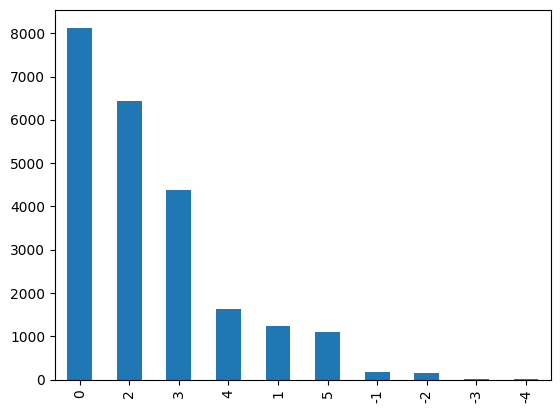

In [65]:
df.depression_stress_score.value_counts().compute().plot(kind='bar')